# Nilearn
Instalamos la librería que nos permite realizar análisis accesibles y versátiles de los volúmenes cerebrales. Proporciona herramientas estadísticas y de aprendizaje automático, con documentación instructiva. Tiene una variedad de conjuntos de datos preprocesados ​​que podemos descargar fácilmente con una función integrada.

In [ ]:
# Verificamos si nilearn está instalado
try:
    import nilearn
except ImportError:
    # sino, instalamos la librería
    %pip install nilearn

# Dataset
Importamos la librería, y usaremos el conjunto de datos de acceso público ADHD-200 compuesto por IRMf(Imagen por resonancia magnética funcional) en estado de reposo y datos anatómicos.
[ADHD200](http://fcon_1000.projects.nitrc.org/indi/adhd200/)

In [ ]:
from nilearn import datasets
num = 40
tdah_datos = datasets.fetch_adhd(n_subjects = num)

# Keys
Usamos .keys() para inspeccionar el conjunto de datos, existen 4 tipos de atributos:



1.   "func" presenta las rutas a las imágenes de datos rs-fMRI
2.   "confounds" son los archivos CSV que contienen variables
3.   “phenotypic” proporciona explicaciones para los pasos de preprocesamiento
4.   “description” es una descripción del conjunto de datos


In [ ]:
tdah_datos.keys()

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

In [ ]:
import nibabel as nib

img = nib.load(tdah_datos.func[0])
img.shape

(61, 73, 61, 176)

Ahora, esto nos dice que para cada paciente hay 176 volúmenes, cada uno con una estructura 3D de (61,73,61)

In [ ]:
print(img)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (61, 73, 61, 176)
affine:
[[  -3.   -0.   -0.   90.]
 [  -0.    3.   -0. -126.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 48
dim             : [  4  61  73  61 176   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  3.  3.  3.  2.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 60
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_c

In [ ]:
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 19.6 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



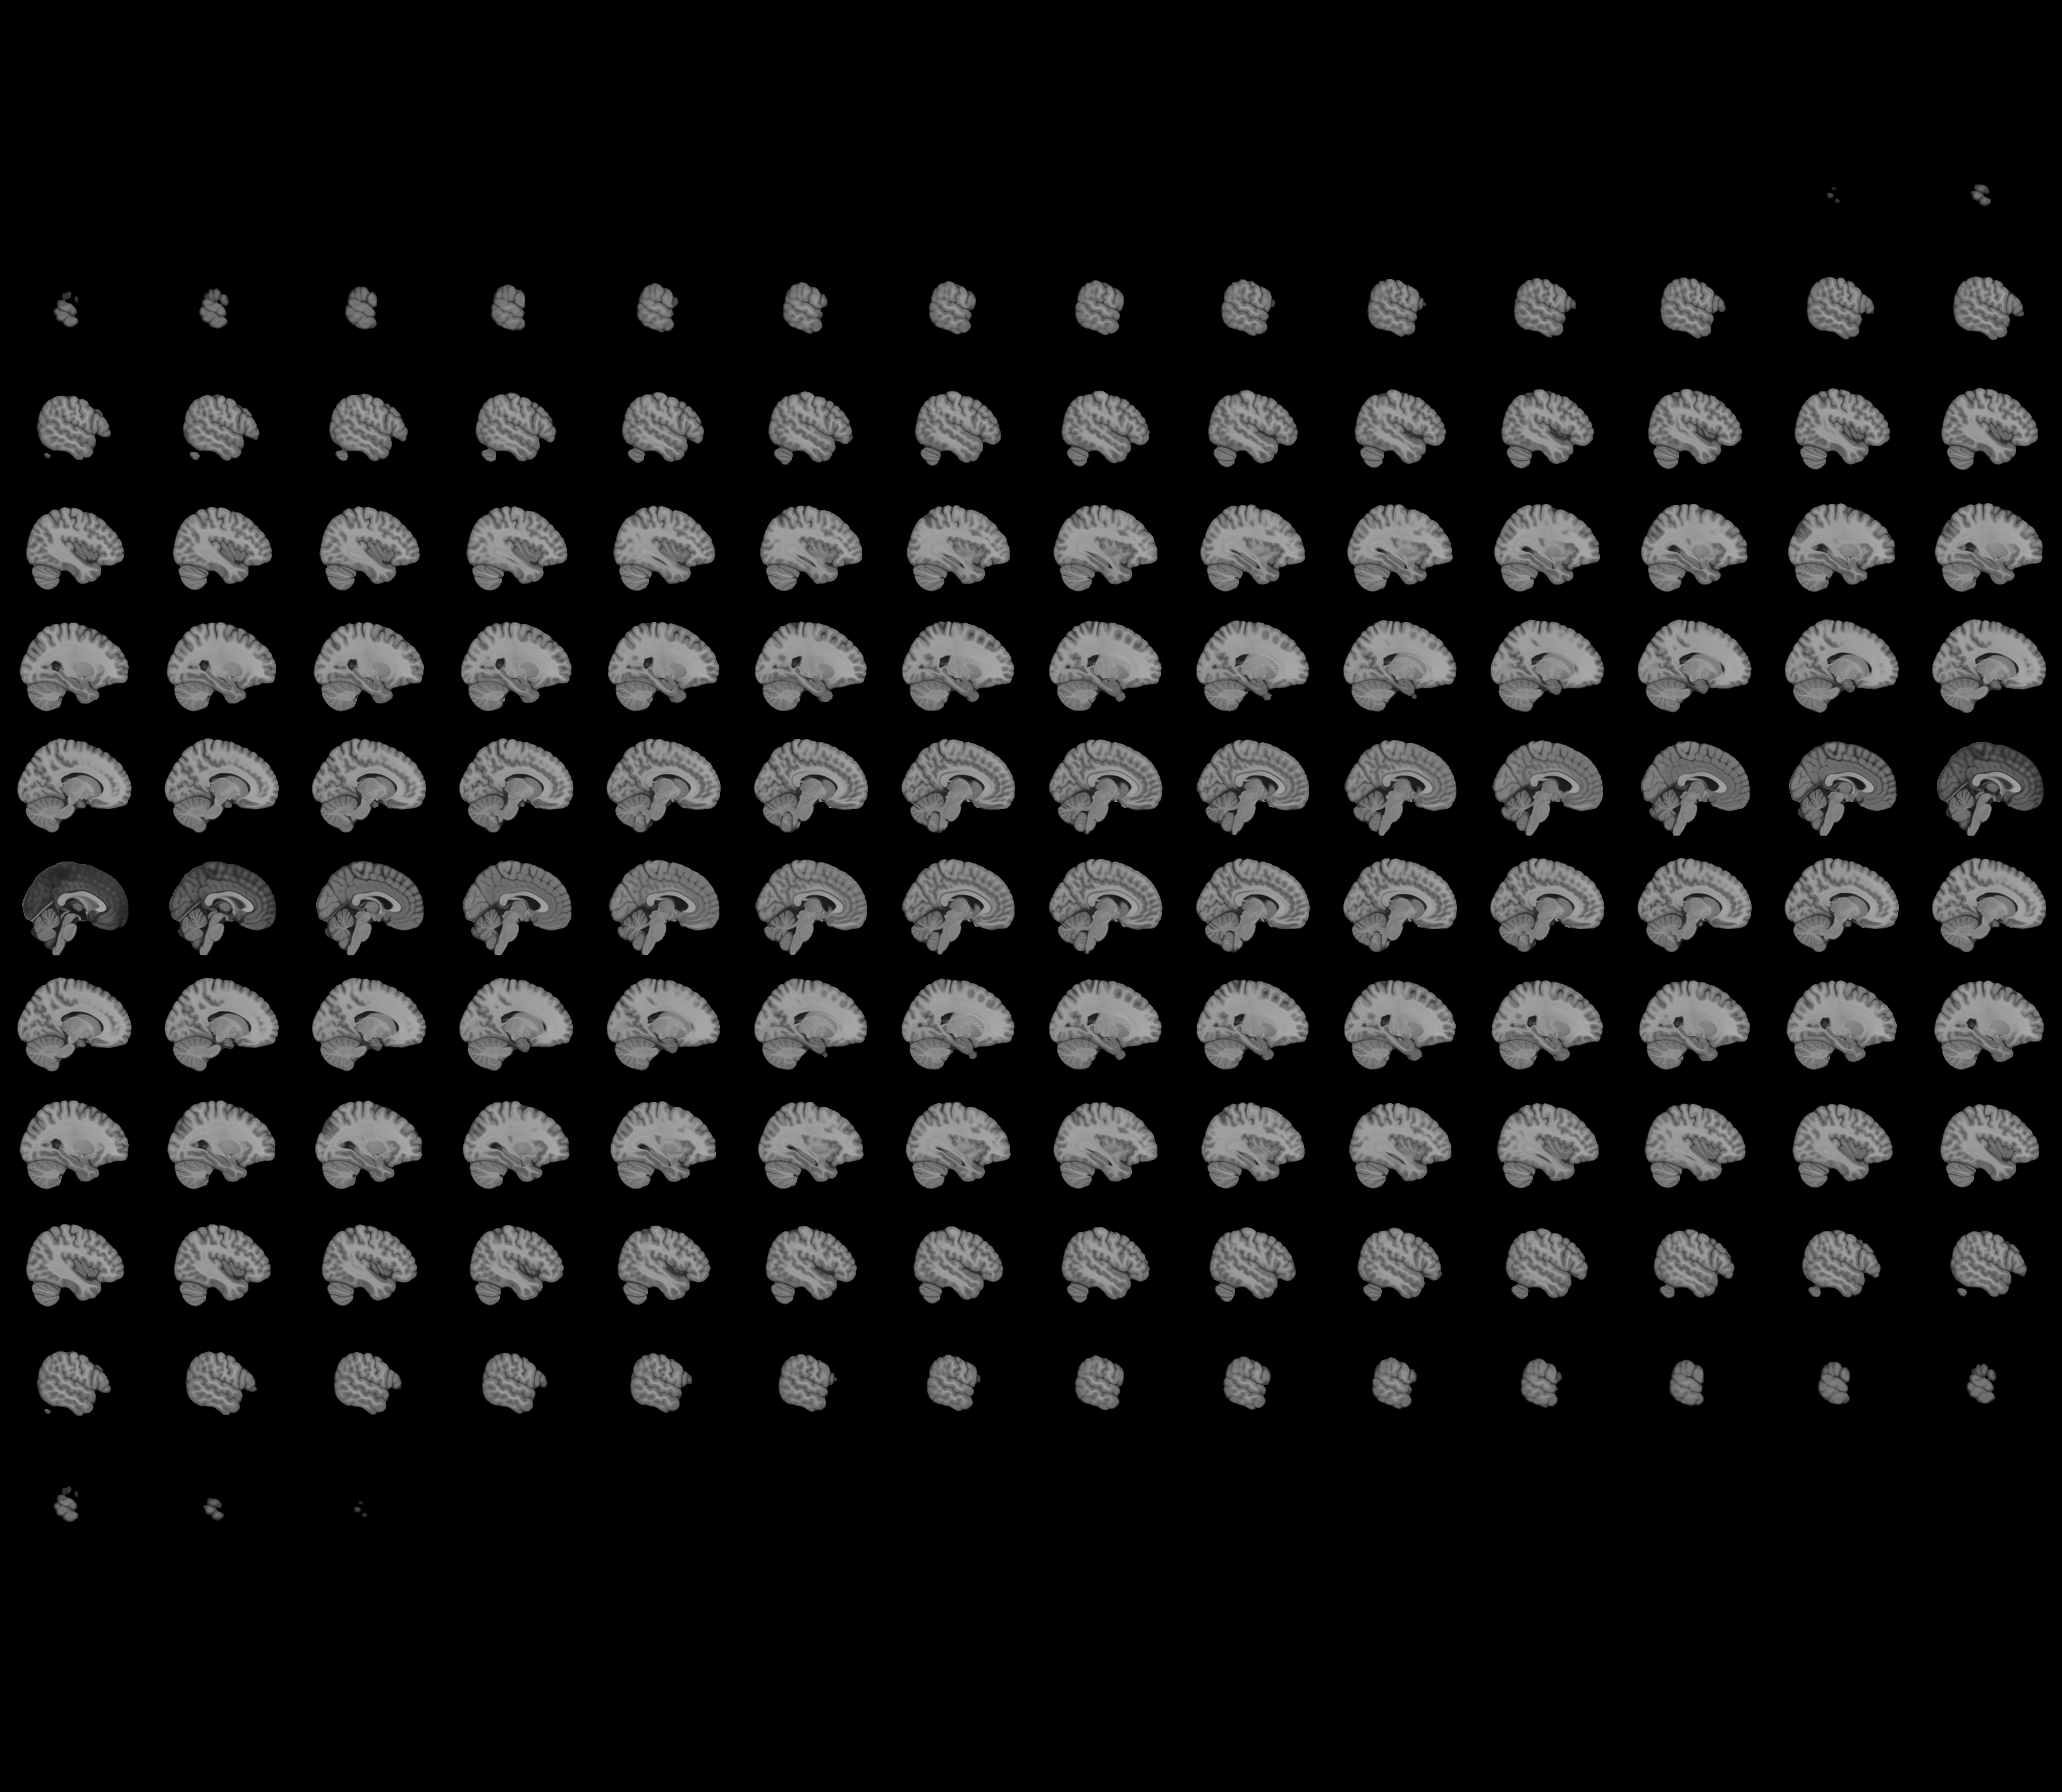
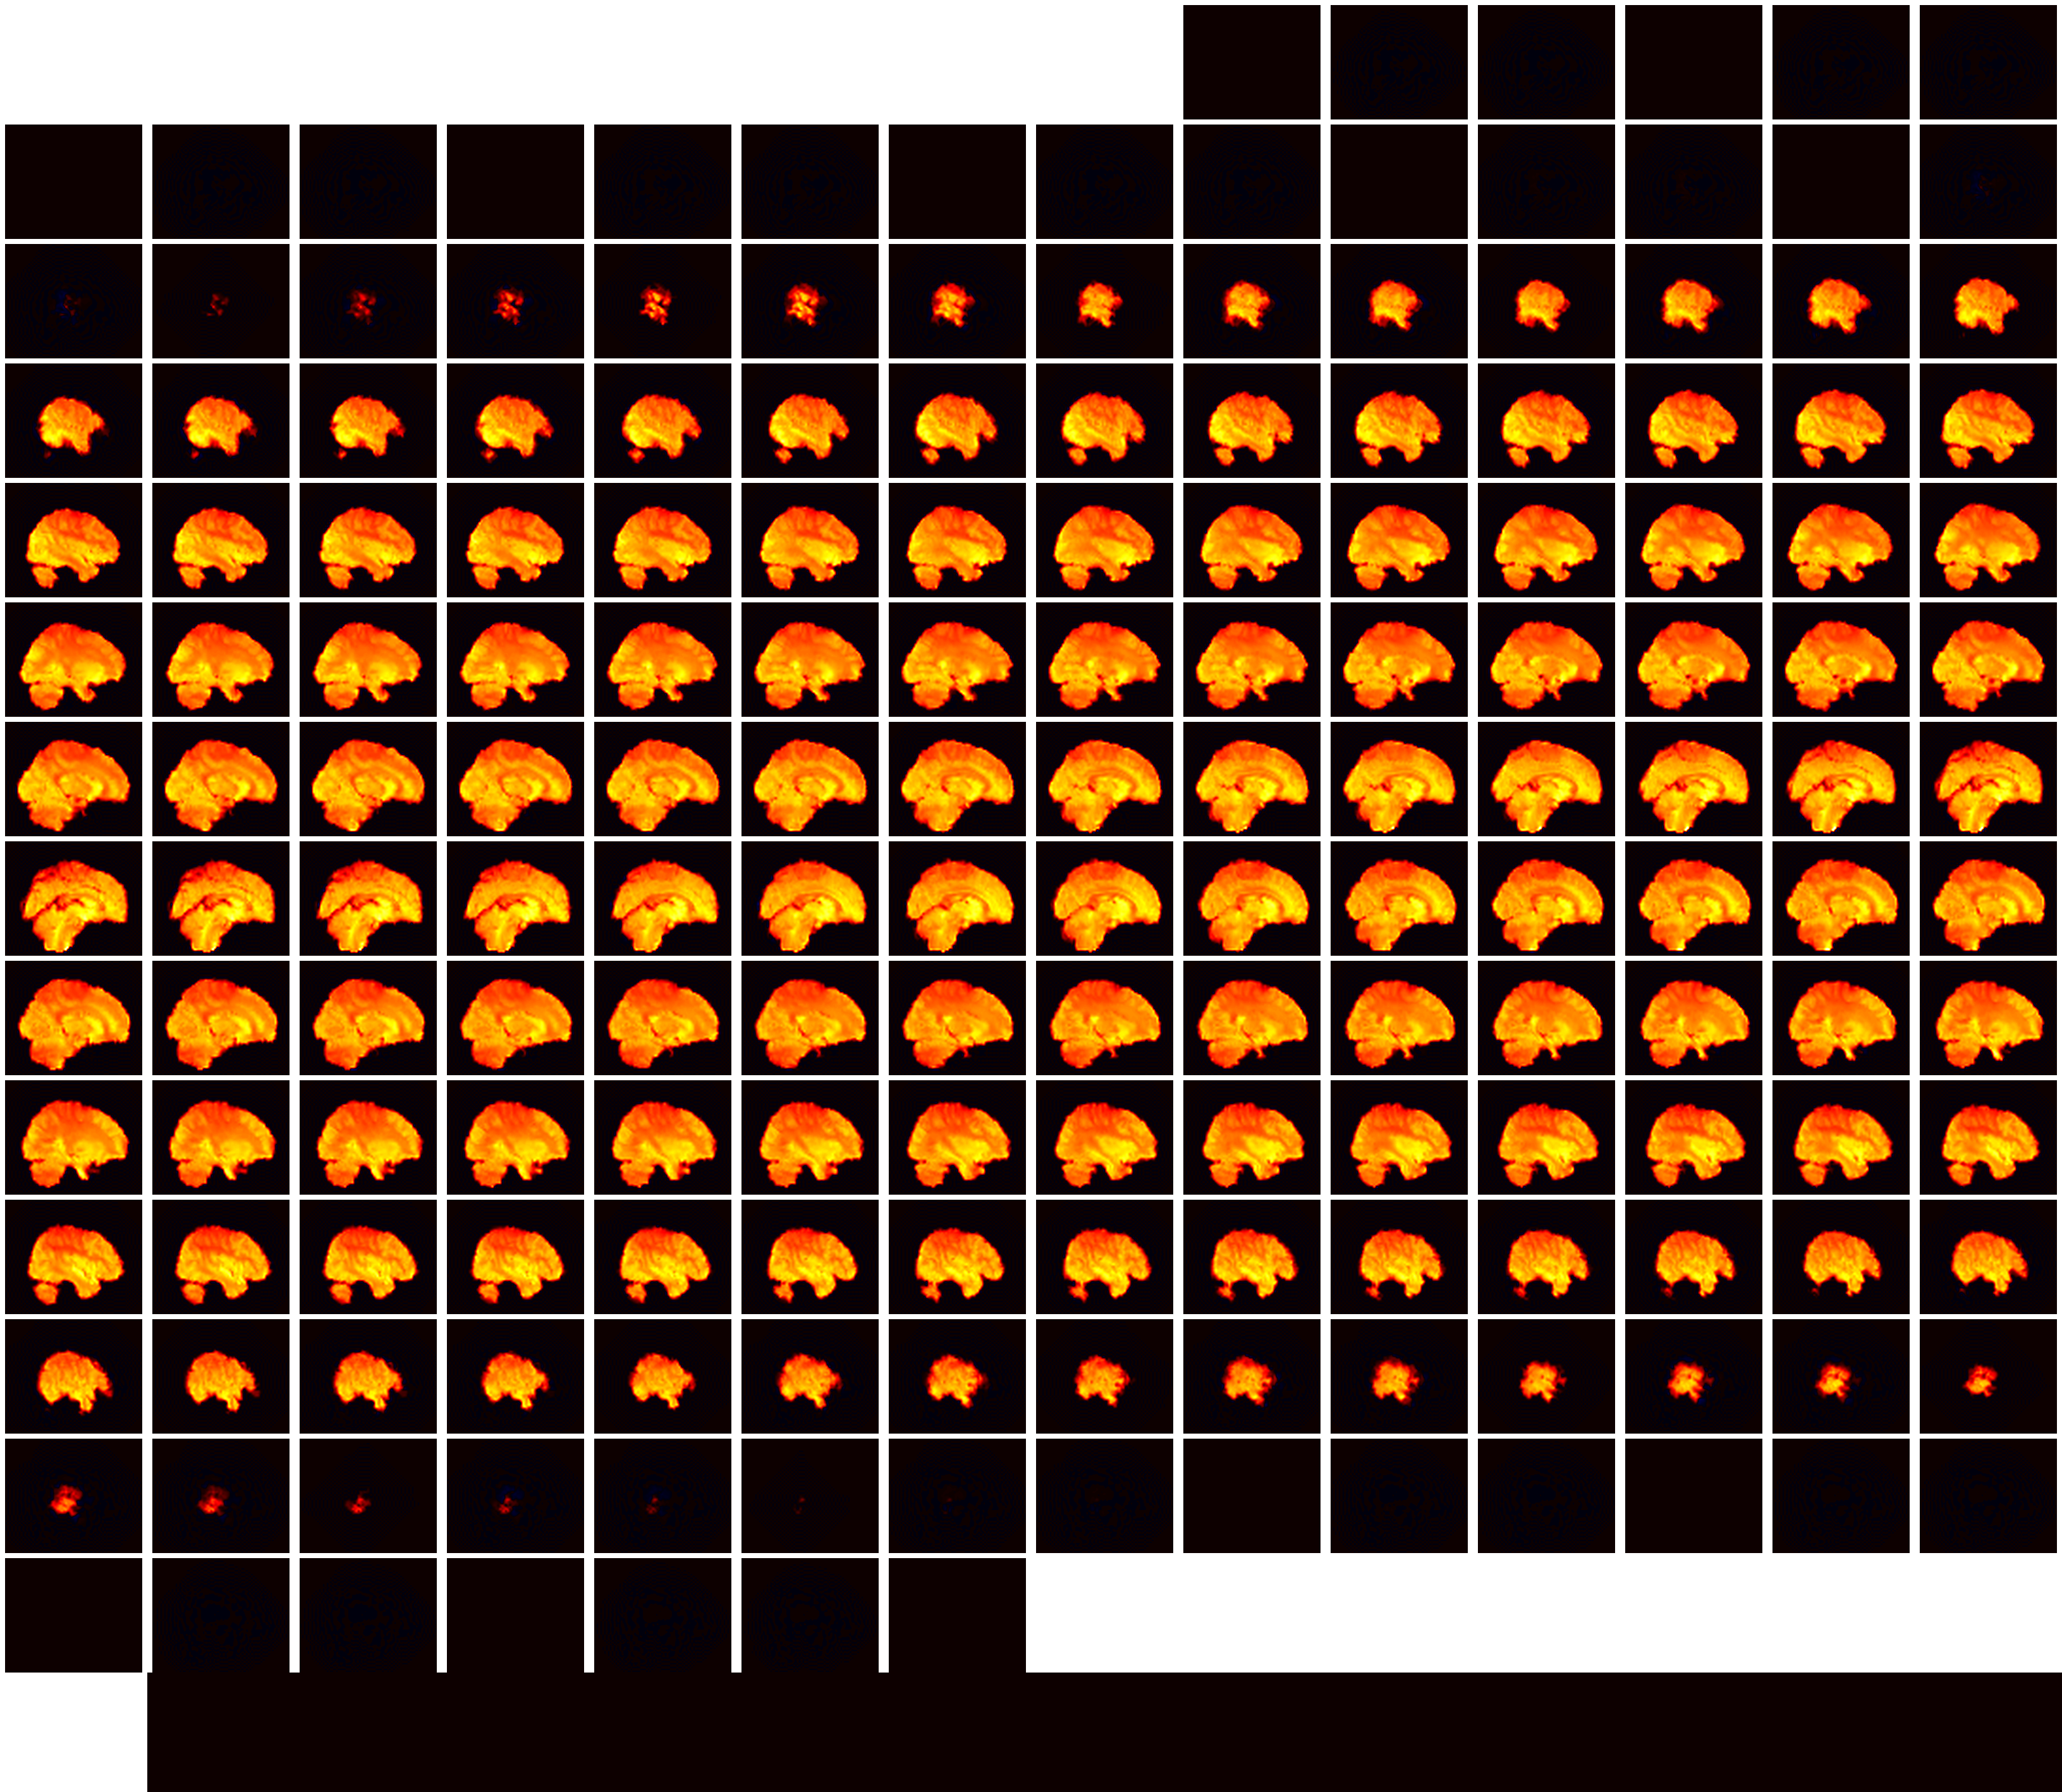

In [ ]:
import matplotlib.pyplot as plt
from nilearn import image
from nilearn import plotting

imagen_xyz = image.mean_img(tdah_datos.func[0])
plotting.view_img(imagen_xyz, threshold = None,colorbar = False)

# Objetivo

Este conjunto de datos presenta tanto a individuos bajo ("controles") como a aquellos con TDAH diagnosticado ("tratamientos").

Extraeremos los coeficientes de conectividad funcional de este conjunto de datos para clasificar si un sujeto determinado es un "control" o un "tratamiento".

Lo haremos usando primero un Análisis de componentes independientes (ICA) de nilearn y luego lo usaremos para extraer coeficientes de conectividad funcional. Finalmente, construiremos una red neuronal utilizando estos coeficientes para clasificar "controles" de "tratamientos".

#Elección de regiones de interés

# Parcelación con MSDL Atlas
visualizaremos el atlas MSDL (aprendizaje de diccionario de múltiples temas), que define un conjunto de ROI probabilísticos en todo el cerebro.

In [ ]:
import numpy as np

msdl_atlas = datasets.fetch_atlas_msdl()

msdl_coordenadas = msdl_atlas.region_coords
n_regiones = len(msdl_coordenadas)

print('MSDL tiene {} ROIs, parte de las siguientes redes : \n {}'.format(n_regiones, np.unique(msdl_atlas.networks)))


Dataset created in /root/nilearn_data/msdl_atlas

MSDL tiene 39 ROIs, parte de las siguientes redes : 
 ['Ant IPS' 'Aud' 'Basal' 'Cereb' 'Cing-Ins' 'D Att' 'DMN' 'Dors PCC'
 'L V Att' 'Language' 'Motor' 'Occ post' 'R V Att' 'Salience' 'Striate'
 'Temporal' 'Vis Sec']


 ...done. (1 seconds, 0 min)
Extracting data from /root/nilearn_data/msdl_atlas/8eaecb9e05c478f565847000d9902a25/MSDL_rois.zip..... done.


Entonces, estos son las reguiones de interés según el atlas MSDL.

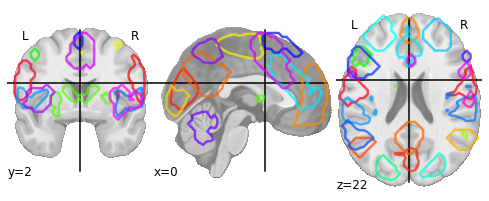

In [ ]:
plotting.plot_prob_atlas(msdl_atlas.maps)

In [ ]:
from nilearn import input_data
masker_msdl = input_data.NiftiMapsMasker(msdl_atlas.maps,resampling_target="data", detrend = True,
                                      standardize=True,smoothing_fwhm=6,memory='nilearn_cache',memory_level=1).fit()

sujetos_msdl = []
for func_file, confound_file in zip(
tdah_datos.func, tdah_datos.confounds):
  series_de_tiempo_msdl = masker_msdl.transform(func_file, confounds=confound_file)
  sujetos_msdl.append(series_de_tiempo_msdl)


/usr/local/lib/python3.8/dist-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.8/dist-packages/nilearn/maskers/nifti_maps_masker.py:586: UserWarning: Persisting input arguments took 0.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, labels_ = self._cache(


In [ ]:
from nilearn import input_data
masker_msdl = input_data.NiftiMapsMasker(msdl_atlas.maps,resampling_target="data", detrend = True,
                                      standardize=True,smoothing_fwhm=6,memory='nilearn_cache',memory_level=1).fit()
seriest = masker_msdl.transform(tdah_datos.func[0])
print(f"Serie de tiempo con la siguiente forma: {seriest}")

Serie de tiempo con la siguiente forma: [[-0.47890148 -1.15256715  0.16546793 ...  0.69850469  0.23391786
   0.963191  ]
 [-1.23173329 -1.4689086   0.97646158 ...  0.30496137 -0.42910059
  -0.17408726]
 [-0.39739011 -0.76309774  1.4037323  ... -0.16787003 -1.84361961
   0.29625011]
 ...
 [-0.49582468 -0.70716384  0.31202038 ... -0.62184783 -1.55206063
  -0.05291351]
 [-0.25279355 -1.21781021  0.77614649 ...  0.22797886 -1.668855
  -0.40818981]
 [-0.28292805 -0.39204645  0.7608094  ... -0.34295337 -0.8248275
  -1.03776746]]


# Parcelación usando BSC(bootstrap analysis of stable clusters)

In [ ]:
basc = datasets.fetch_atlas_basc_multiscale_2015()


Dataset created in /root/nilearn_data/basc_multiscale_2015



 ...done. (1 seconds, 0 min)
Extracting data from /root/nilearn_data/basc_multiscale_2015/53337d5c408465aa257d35f81c13413b/1861819..... done.


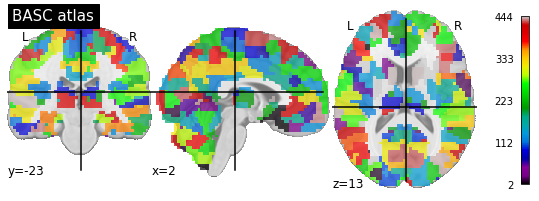

In [ ]:
plotting.plot_roi(basc["scale444"],title = "BASC atlas",colorbar = True, cmap = "nipy_spectral")

In [ ]:
masker_basc = input_data.NiftiLabelsMasker(basc['scale444'],resampling_target = "data",detrend = True,
                                      standardize=True,smoothing_fwhm=5,memory='nilearn_cache',memory_level=1).fit()
sujetos_basc = []
for func_file, confound_file in zip(
  tdah_datos.func, tdah_datos.confounds):
  series_de_tiempo_basc = masker_basc.transform(func_file, confounds=confound_file)
  sujetos_basc.append(series_de_tiempo_basc)

In [ ]:
print(f"Serie de tiempo con la siguiente forma:{sujetos_basc[0].shape} (#Puntos en el tiempo,#Parcelas)")

Serie de tiempo con la siguiente forma:(176, 444) (#Puntos en el tiempo,#Parcelas)


# Agrupación jerárquica


In [ ]:
from nilearn.connectome import ConnectivityMeasure
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

conn_basc = ConnectivityMeasure(kind='correlation').fit(sujetos_basc)
sucesor = linkage(conn_basc.mean_, method='average', metric='euclidean')

/usr/local/lib/python3.8/dist-packages/nilearn/regions/signal_extraction.py:231: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(labels_img, data, target_affine)


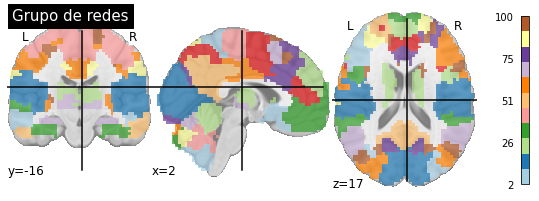

In [ ]:
part_basc = np.squeeze(cut_tree(sucesor,n_clusters=100))
part_basc_img = masker_basc.inverse_transform(part_basc.reshape([1,444])+1)

plotting.plot_roi(part_basc_img,title='Grupo de redes',colorbar=True,cmap='Paired')

Parcelación

In [ ]:
masker_basc_cluster = input_data.NiftiLabelsMasker(part_basc_img, smoothing_fwhm=6,
 standardize=False, detrend=True,
 t_r=2.5, low_pass=0.1,
 high_pass=0.01).fit()

sujetos_basc_cluster = []
for func_file, confound_file in zip(
  tdah_datos.func, tdah_datos.confounds):
  series_de_tiempo_basc_cluster = masker_basc_cluster.transform(func_file, confounds=confound_file)
  sujetos_basc_cluster.append(series_de_tiempo_basc_cluster)

In [ ]:
print(f"Serie de tiempo con la siguiente forma: {sujetos_basc_cluster[0].shape} (#Puntos en el tiempo,#Parcelas)")

Serie de tiempo con la siguiente forma: (176, 100) (#Puntos en el tiempo,#Parcelas)


# Parcelación agrupado pabellones cerebrales

In [ ]:
from nilearn.regions import Parcellations

ward = Parcellations(method='ward', n_parcels=400,
                     standardize=False, smoothing_fwhm=10.,
                     memory='nilearn_cache', memory_level=1,
                     verbose=1)
ward.fit(tdah_datos.func)

[MultiNiftiMasker.fit] Loading data from [/root/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz,
 /root/nilearn_data/adhd/data/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz,
 /root/nilearn_data/adhd/data/0010128/0010128_rest_tshift_RPI_voreg_mni.nii.gz,
 /root/nilearn_data/adhd/data/0021019/0021019_rest_tshift_RPI_voreg_mni.nii.gz,
 /root/nilearn_data/adhd/data/0023008/0023008_rest_tshift_RPI_voreg_mni.nii.gz,
 /root/nilearn_data/adhd/data/0023012/0023012_rest_tshift_RPI_voreg_mni.nii.gz,
 /root/nilearn_data/adhd/data/0027011/0027011_rest_tshift_RPI_voreg_mni.nii.gz,
 /root/nilearn_data/adhd/data/0027018/0027018_rest_tshift_RPI_voreg_mni.nii.gz,
 /root/nilearn_data/adhd/data/0027034/0027034_rest_tshift_RPI_voreg_mni.nii.gz,
 /root/nilearn_data/adhd/data/0027037/0027037_rest_tshift_RPI_voreg_mni.nii.gz,
 /root/nilearn_data/adhd/data/1019436/1019436_rest_tshift_RPI_voreg_mni.nii.gz,
 /root/nilearn_data/adhd/data/1206380/1206380_rest_tshift_RPI_voreg_mni.nii.gz,

/usr/local/lib/python3.8/dist-packages/nilearn/_utils/cache_mixin.py:223: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


[Parcellations] Loading data
[Parcellations] computing ward


Parcellations(memory=Memory(location=nilearn_cache/joblib), memory_level=1,
              method='ward', n_parcels=400, smoothing_fwhm=10.0)

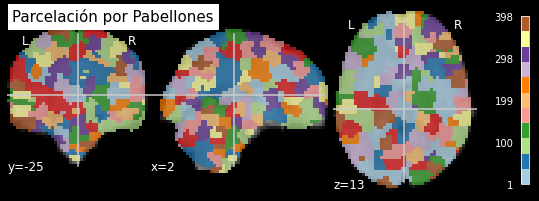

In [ ]:
from nilearn.image import mean_img

etiquetas_ward_img = ward.labels_img_

mean_func_img = mean_img(tdah_datos.func[0])
plotting.plot_roi(etiquetas_ward_img, mean_func_img,title="Parcelación por Pabellones",cut_coords=(2,-25,13),colorbar=True,cmap='Paired')

In [ ]:
masker_ward = input_data.NiftiLabelsMasker(etiquetas_ward_img, smoothing_fwhm=6,
 standardize=False, detrend=True,
 t_r=2.5, low_pass=0.1,
 high_pass=0.01).fit()

sujetos_ward = []
for func_file, confound_file in zip(
  tdah_datos.func, tdah_datos.confounds):
  series_de_tiempo_ward = masker_ward.transform(func_file, confounds=confound_file)
  sujetos_ward.append(series_de_tiempo_ward)

In [ ]:
print(f"Serie de tiempo con la siguiente forma: {sujetos_ward[0].shape} (#Puntos en el tiempo,#Parcelas)")

Serie de tiempo con la siguiente forma: (176, 400) (#Puntos en el tiempo,#Parcelas)


#Análisis de componentes independientes (ICA)
Lo utilizamos para evaluar la conectividad funcional. Nilearn tiene un método para ICA a nivel de grupo (CanICA) que permite controlar la variabilidad de un solo sujeto, especialmente dado que estamos interesados ​​en redes funcionales.

Elegimos usar una descomposición de 20 componentes(basada en los estándares proporcionados en la documentación de Nilearn para el conjunto de datos elegido).

In [ ]:
from nilearn import decomposition

canica = decomposition.CanICA(n_components=20,mask_strategy = 'background')
canica.fit(tdah_datos.func)

#Recuperamos los componentes
componentes = canica.components_

#Utilizamos masker para obtener los componentes independientes
componentes_img = canica.masker_.inverse_transform(componentes)


#Masker
Utilizamos ICA como un filtro para extraer las regiones que nos interesan. Lo hacemos llamando a la función NiftiMapsMasker de Nilearn para "resumir" las señales cerebrales que obtuvimos usando ICA. Una vez que tenemos eso, transformamos los datos extraídos en series de tiempo usando el método fit_transform.
Luego usamos todo lo que sabemos sobre el conjunto de datos (archivos "función", "confundidos" y "fenotípicos") para obtener la información que necesitamos, incluso si el sujeto es "tratamiento" o "control" y su ubicación de recopilación de datos asociada ( sitio).
Contabilización de fuentes de ruido
Los enmascaradores nos permiten realizar otras operaciones útiles además de crear nuestros datos.
Un paso importante de preprocesamiento es la corrección de las señales medidas sin interés (por ejemplo, el movimiento de la cabeza). Nuestro als adhd_data incluye varias de estas señales sin interés. Podemos acceder a estos usando el atributo de confusión, usando adhd_data.confounds.

In [ ]:
import pandas as pd

pd.read_table(tdah_datos.confounds[0]).head()

csf  constant  linearTrend           wm       global  \
0  12140.708282       1.0          0.0  9322.722489  9955.469315   
1  12123.146913       1.0          1.0  9314.257684  9947.987176   
2  12085.963127       1.0          2.0  9319.610045  9945.132852   
3  12109.299348       1.0          3.0  9299.841075  9943.648622   
4  12072.330305       1.0          4.0  9297.870869  9925.640852   

   motion-pitch  motion-roll  motion-yaw  motion-x  motion-y  motion-z  \
0       -0.0637       0.1032     -0.1516   -0.0376   -0.0112    0.0840   
1       -0.0708       0.0953     -0.1562   -0.0198    0.0021    0.0722   
2       -0.0795       0.0971     -0.1453   -0.0439   -0.0241    0.0972   
3       -0.0607       0.0918     -0.1601   -0.0418   -0.0133    0.0877   
4       -0.0706       0.0873     -0.1482   -0.0313   -0.0118    0.0712   

             gm  compcor1  compcor2  compcor3  compcor4  compcor5  
0  10617.938409 -0.035058 -0.006713 -0.071532  0.009847 -0.027601  
1  10611.036827 -0.026949 -0.091152 -0.030126  0.020055 -0.099798  
2  10591.877177  0.002552  0.069165  0.090166 -0.016608 -0.071980  
3  10592.008336  0.079391  0.029959 -0.098036  0.062493  0.024105  
4  10570.445905  0.075471 -0.030123  0.084739  0.088217  0.012996

In [ ]:
#Uso de un filtro para extraer las series temporales de las regiones
from nilearn import input_data

masker_canica = input_data.NiftiMapsMasker(componentes_img, smoothing_fwhm=6,
 standardize=False, detrend=True,
 t_r=2.5, low_pass=0.1,
 high_pass=0.01)


#Cómputo de las señales de las regiones y extracción de la información fenotípica de interés
sujetos_canica = []
sitios = []
etiquetas = []

#transformamos los datos extraídos en series de tiempo usando el método fit_transform. Luego usamos todo lo que sabemos sobre el conjunto de datos
#(de los archivos “func”, “confounds”, and “phenotypic” files) para obtener la información que necesitamos, incluso si el sujeto es "tratamiento"
#o "control" y su ubicación de recopilación de datos asociada( sitio).

for func_file, confound_file, phenotypic in zip(
  tdah_datos.func, tdah_datos.confounds, tdah_datos.phenotypic):
  series_de_tiempo_canica = masker_canica.fit_transform(func_file, confounds=confound_file)
  sujetos_canica.append(series_de_tiempo_canica)
  sitios.append(phenotypic['site'])
  etiquetas.append(phenotypic['adhd'])

In [ ]:
print(len(sujetos_canica))
sujetos_canica[0].shape

40


(176, 20)

Ahora, aquí podemos ver que tenemos 20 ROI

# Conectomas
Ahora, necesitamos obtener la conectividad funcional entre las regiones de interés que extrajimos. El tipo de conectividad funcional más simple y más utilizado es la correlación por pares entre ROI.

In [ ]:
from nilearn.connectome import ConnectivityMeasure

medida_correlacion = ConnectivityMeasure(kind='correlation')
correlacion_matrices_msdl = medida_correlacion.fit_transform(sujetos_msdl)
correlacion_matrices_basc = medida_correlacion.fit_transform(sujetos_basc_cluster)
correlacion_matrices_ward = medida_correlacion.fit_transform(sujetos_ward)
correlacion_matrices_canica = medida_correlacion.fit_transform(sujetos_canica)


In [ ]:
print(correlacion_matrices_msdl.shape)
print(correlacion_matrices_basc.shape)
print(correlacion_matrices_ward.shape)
print(correlacion_matrices_canica.shape)

(40, 39, 39)
(40, 100, 100)
(40, 400, 400)
(40, 20, 20)


In [ ]:
#Separación de las matrices en las de los sujetos de tratamiento frente a los de control para la comparación.
#Visualicemos la diferencia en el conectoma de aquellos en tratamiento o sujetos de control.
tdah_correlaciones_msdl = []
control_correlaciones_msdl = []

tdah_correlaciones_basc = []
control_correlaciones_basc = []

tdah_correlaciones_ward = []
control_correlaciones_ward = []

tdah_correlaciones_canica = []
control_correlaciones_canica = []

for i in range(40):
    if etiquetas[i] == 1:
        tdah_correlaciones_msdl.append(correlacion_matrices_msdl[i])
        tdah_correlaciones_basc.append(correlacion_matrices_basc[i])
        tdah_correlaciones_ward.append(correlacion_matrices_ward[i])
        tdah_correlaciones_canica.append(correlacion_matrices_canica[i])
    else:
        control_correlaciones_msdl.append(correlacion_matrices_msdl[i])
        control_correlaciones_basc.append(correlacion_matrices_basc[i])
        control_correlaciones_ward.append(correlacion_matrices_ward[i])
        control_correlaciones_canica.append(correlacion_matrices_canica[i])

#Obtener la matriz de correlación media en todos los sujetos de tratamiento
correlacion_media_msdl_tdah = np.mean(tdah_correlaciones_msdl, axis=0).reshape(series_de_tiempo_msdl.shape[-1],
                                                          series_de_tiempo_msdl.shape[-1])
correlacion_media_basc_tdah = np.mean(tdah_correlaciones_basc, axis=0).reshape(series_de_tiempo_basc_cluster.shape[-1],
                                                          series_de_tiempo_basc_cluster.shape[-1])
correlacion_media_ward_tdah = np.mean(tdah_correlaciones_ward, axis=0).reshape(series_de_tiempo_ward.shape[-1],
                                                          series_de_tiempo_ward.shape[-1])
correlacion_media_canica_tdah = np.mean(tdah_correlaciones_canica, axis=0).reshape(series_de_tiempo_canica.shape[-1],
                                                          series_de_tiempo_canica.shape[-1])

#Obtener la matriz de correlación media en todos los sujetos de control
correlacion_media_msdl_control = np.mean(control_correlaciones_msdl, axis=0).reshape(series_de_tiempo_msdl.shape[-1],
                                                          series_de_tiempo_msdl.shape[-1])
correlacion_media_basc_control = np.mean(control_correlaciones_basc, axis=0).reshape(series_de_tiempo_basc_cluster.shape[-1],
                                                          series_de_tiempo_basc_cluster.shape[-1])
correlacion_media_ward = np.mean(control_correlaciones_ward, axis=0).reshape(series_de_tiempo_ward.shape[-1],
                                                          series_de_tiempo_ward.shape[-1])
correlacion_media_canica_control = np.mean(control_correlaciones_canica, axis=0).reshape(series_de_tiempo_canica.shape[-1],
                                                          series_de_tiempo_canica.shape[-1])

#Calsificación NN
Ahora que tenemos las matrices de correlación que proporcionan una medida vectorizada de conectividad funcional, podemos usarlas como datos de entrada para nuestra red neuronal.

In [ ]:
conectividad = ConnectivityMeasure(kind = 'correlation',vectorize = True)
conectomas_msdl = conectividad.fit_transform(sujetos_msdl)
conectomas_basc = conectividad.fit_transform(sujetos_basc)
conectomas_ward = conectividad.fit_transform(sujetos_ward)
conectomas_canica = conectividad.fit_transform(sujetos_canica)
print(conectomas_msdl.shape)
print(conectomas_basc.shape)
print(conectomas_ward.shape)
print(conectomas_canica.shape)

(40, 780)
(40, 98790)
(40, 80200)
(40, 210)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.9)
pca.fit(conectomas_msdl)
conectomas_msdl = pca.transform(conectomas_msdl)

pca.fit(conectomas_basc)
conectomas_basc = pca.transform(conectomas_basc)

pca.fit(conectomas_ward)
conectomas_ward = pca.transform(conectomas_ward)

pca.fit(conectomas_canica)
conectomas_canica = pca.transform(conectomas_canica)

print(conectomas_msdl.shape)
print(conectomas_basc.shape)
print(conectomas_ward.shape)
print(conectomas_canica.shape)

(40, 29)
(40, 32)
(40, 32)
(40, 28)


In [ ]:
#Dividimos los datos

from sklearn.model_selection import train_test_split
X_train_msdl, X_test_msdl, y_train_msdl, y_test_msdl = train_test_split(conectomas_msdl, etiquetas, test_size=0.15)
X_train_basc, X_test_basc, y_train_basc, y_test_basc = train_test_split(conectomas_basc, etiquetas, test_size=0.15)
X_train_ward, X_test_ward, y_train_ward, y_test_ward = train_test_split(conectomas_ward, etiquetas, test_size=0.15)
X_train_canica, X_test_canica, y_train_canica, y_test_canica = train_test_split(conectomas_canica, etiquetas, test_size=0.15)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

clasificador = Sequential()

#Primera capa oculta
clasificador.add(Dense(32, activation='tanh', kernel_initializer='random_normal', input_shape=conectomas_msdl.shape[1:]))
#Segunda capa oculta
clasificador.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Tercera capa oculta
clasificador.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
#Capa de salida
clasificador.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
#Compilamos el modelo
clasificador.compile(optimizer = Adam(lr =.0005),loss='binary_crossentropy', metrics =['accuracy'])
#Entreamos el modelo
clasificador.fit(np.array(X_train_msdl),np.array(y_train_msdl), batch_size=8, epochs=100)

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


5/5 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.3824
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.6176
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5588
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5588
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5588
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5588
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5588
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5588
Epoch 9/100
5/5 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5588
Epoch 10/100
5/5 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5588
Epoch 11/100
5/5 [=======================

In [ ]:
eval_modelo=clasificador.evaluate(np.array(X_train_msdl), np.array(y_train_msdl))
eval_modelo

2/2 [==============================] - 0s 10ms/step - loss: 0.0222 - accuracy: 1.0000


[0.022212469950318336, 1.0]

In [ ]:
y_pred_msdl=clasificador.predict(X_test_msdl,batch_size=16)
y_pred_msdl =(y_pred_msdl>0.5)

from sklearn.metrics import confusion_matrix, classification_report

mc = confusion_matrix(y_test_msdl, y_pred_msdl)
print(mc)
rp = classification_report(y_test_msdl, y_pred_msdl)
print(rp)

1/1 [==============================] - 0s 72ms/step
[[3 2]
 [0 1]]
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.33      1.00      0.50         1

    accuracy                           0.67         6
   macro avg       0.67      0.80      0.62         6
weighted avg       0.89      0.67      0.71         6



In [ ]:
clasificador = Sequential()

#Primera capa oculta
clasificador.add(Dense(32, activation='tanh', kernel_initializer='random_normal', input_shape=conectomas_basc.shape[1:]))
#Segunda capa oculta
clasificador.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Tercera capa oculta
clasificador.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
#Capa de salida
clasificador.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
#Compilamos el modelo
clasificador.compile(optimizer = Adam(lr =.0005),loss='binary_crossentropy', metrics =['accuracy'])
#Entrenamos el modelo
clasificador.fit(np.array(X_train_basc),np.array(y_train_basc), batch_size=8, epochs=75)

Epoch 1/75


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


5/5 [==============================] - 1s 4ms/step - loss: 0.6926 - accuracy: 0.7353
Epoch 2/75
5/5 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.7941
Epoch 3/75
5/5 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.8529
Epoch 4/75
5/5 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.8824
Epoch 5/75
5/5 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.8824
Epoch 6/75
5/5 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.8824
Epoch 7/75
5/5 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.8824
Epoch 8/75
5/5 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.8824
Epoch 9/75
5/5 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.8824
Epoch 10/75
5/5 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.9412
Epoch 11/75
5/5 [==============================] -

In [ ]:
eval_modelo=clasificador.evaluate(np.array(X_train_basc), np.array(y_train_basc))
eval_modelo

2/2 [==============================] - 0s 8ms/step - loss: 0.0362 - accuracy: 1.0000


[0.03624904900789261, 1.0]

In [ ]:
y_pred_basc=clasificador.predict(X_test_basc,batch_size=16)
y_pred_basc =(y_pred_basc>0.5)

from sklearn.metrics import confusion_matrix, classification_report

mc = confusion_matrix(y_test_basc, y_pred_basc)
print(mc)
rp = classification_report(y_test_basc, y_pred_basc)
print(rp)

1/1 [==============================] - 0s 82ms/step
[[1 2]
 [2 1]]
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.33      0.33      0.33         3

    accuracy                           0.33         6
   macro avg       0.33      0.33      0.33         6
weighted avg       0.33      0.33      0.33         6



In [ ]:
clasificador = Sequential()

#Primera capa oculta
clasificador.add(Dense(32, activation='tanh', kernel_initializer='random_normal', input_shape=conectomas_ward.shape[1:]))
#Segunda capa oculta
clasificador.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Tercera capa oculta
clasificador.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Capa de salida
clasificador.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
#Compilamos el modelo
clasificador.compile(optimizer = Adam(lr =.0001),loss='binary_crossentropy', metrics =['accuracy'])
#Entrenamos el modelo
clasificador.fit(np.array(X_train_ward),np.array(y_train_ward), batch_size=8, epochs=75)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/75
5/5 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.5588
Epoch 2/75
5/5 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5294
Epoch 3/75
5/5 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5588
Epoch 4/75
5/5 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5588
Epoch 5/75
5/5 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.5882
Epoch 6/75
5/5 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.6176
Epoch 7/75
5/5 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.6176
Epoch 8/75
5/5 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.6471
Epoch 9/75
5/5 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.6471
Epoch 10/75
5/5 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.6765
Epoch 11/75
5/5 [======================

In [ ]:
eval_modelo=clasificador.evaluate(np.array(X_train_ward), np.array(y_train_ward))
eval_modelo

2/2 [==============================] - 0s 8ms/step - loss: 0.6681 - accuracy: 0.9118


[0.6681409478187561, 0.9117646813392639]

In [ ]:
y_pred_ward=clasificador.predict(X_test_ward,batch_size=8)
y_pred_ward =(y_pred_ward>0.45)

from sklearn.metrics import confusion_matrix, classification_report

mc = confusion_matrix(y_test_ward, y_pred_ward)
print(mc)
rp = classification_report(y_test_ward, y_pred_ward)
print(rp)

1/1 [==============================] - 0s 73ms/step
[[0 4]
 [0 2]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.33      1.00      0.50         2

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
clasificador = Sequential()

#Primera capa oculta
clasificador.add(Dense(32, activation='tanh', kernel_initializer='random_normal', input_shape=conectomas_canica.shape[1:]))
#Segunda capa oculta
clasificador.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Tercera capa oculta
clasificador.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
#Capa de salida
clasificador.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
#Compilamos el modelo
clasificador.compile(optimizer = Adam(lr =.0005),loss='binary_crossentropy', metrics =['accuracy'])
#Entrenamos el modelo
clasificador.fit(np.array(X_train_canica),np.array(y_train_canica), batch_size=16, epochs=75)

Epoch 1/75


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 6ms/step - loss: 0.6931 - accuracy: 0.5294
Epoch 2/75
3/3 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5294
Epoch 3/75
3/3 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5294
Epoch 4/75
3/3 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5294
Epoch 5/75
3/3 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5294
Epoch 6/75
3/3 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5294
Epoch 7/75
3/3 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5294
Epoch 8/75
3/3 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5294
Epoch 9/75
3/3 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5294
Epoch 10/75
3/3 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.5294
Epoch 11/75
3/3 [==============================] -

In [ ]:
eval_modelo=clasificador.evaluate(np.array(X_train_canica), np.array(y_train_canica))
eval_modelo

2/2 [==============================] - 0s 8ms/step - loss: 0.5013 - accuracy: 0.9412


[0.5012931227684021, 0.9411764740943909]

In [ ]:
y_pred_canica=clasificador.predict(X_test_canica)
y_pred_canica =(y_pred_canica>0.5)

from sklearn.metrics import confusion_matrix, classification_report

mc = confusion_matrix(y_test_canica, y_pred_canica)
print(mc)
rp = classification_report(y_test_canica, y_pred_canica)
print(rp)

1/1 [==============================] - 0s 68ms/step
[[0 2]
 [1 3]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.60      0.75      0.67         4

    accuracy                           0.50         6
   macro avg       0.30      0.38      0.33         6
weighted avg       0.40      0.50      0.44         6

